In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ex"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import gym

In [3]:
env = gym.make('Breakout-v0')

In [4]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [5]:
from collections import deque

def preprocess_observation(obs, rot=True):
    img = obs[2:194:2, ::2] # crop and downsize
    #img = (img // 3 - 128).astype(np.int8)
    img = np.mean(img, axis=2) / 255.0
    return img.reshape(96,80)

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0).reshape(96,80,1)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

<IPython.core.display.Javascript object>


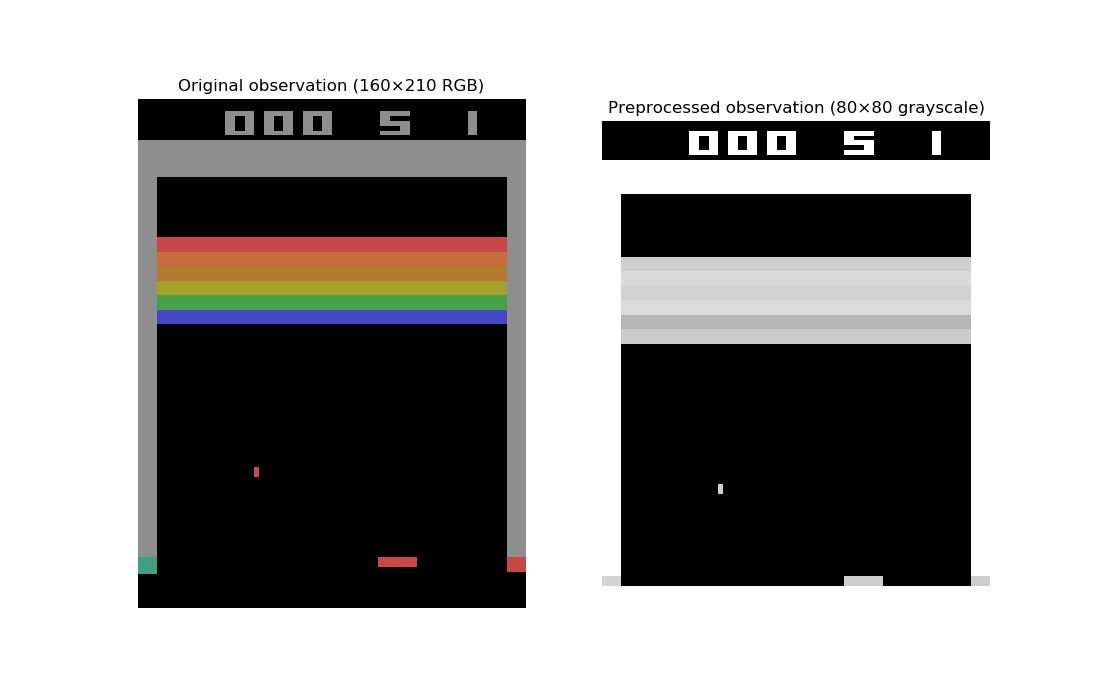

In [6]:
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

<IPython.core.display.Javascript object>


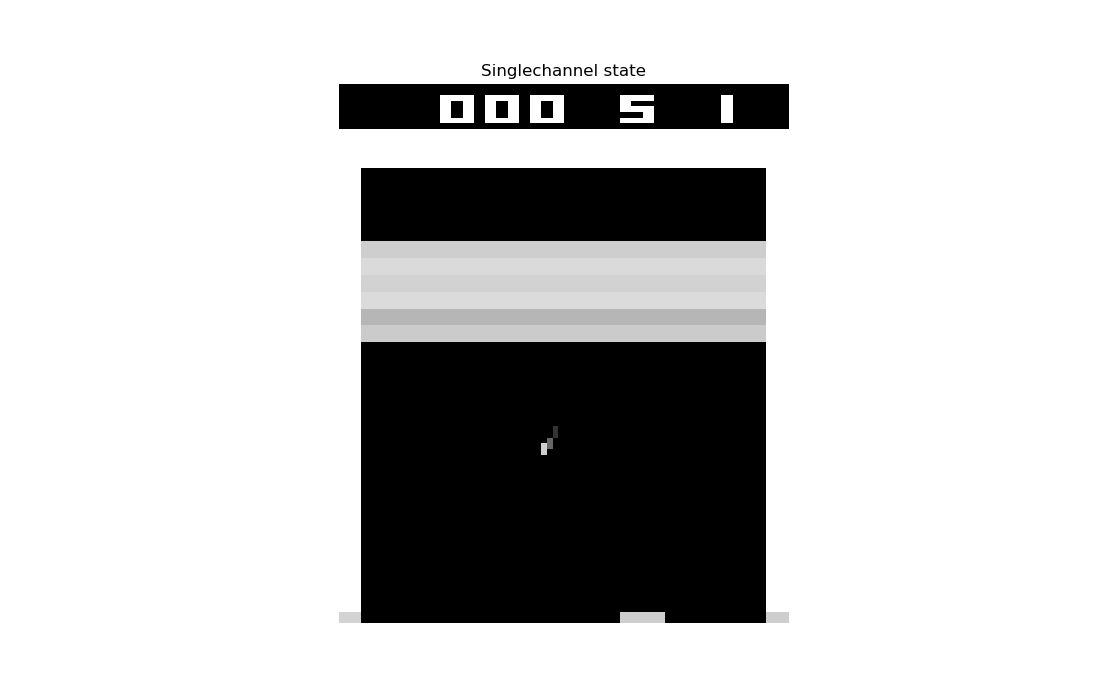

In [7]:
obs = env.reset()
for step in range(3):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

img2 = combine_observations_singlechannel(preprocessed_observations)
plt.figure(figsize=(11, 7))
plt.plot(122)
plt.title("Singlechannel state")
plt.imshow(img2.reshape(96,80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [7]:
import tensorflow as tf
reset_graph()

input_height = 96
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 12 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [8]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [9]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]


In [11]:
replay_memory_size = 150000
replay_memory = ReplayMemory(replay_memory_size)

def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [12]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 6000000

def epsilon_greedy(q_values, step, ball_is_running = True):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        if not ball_is_running:
            action = 1 # Fire
        else:
            action = np.random.randint(n_outputs) # random action
    else:
        action = np.argmax(q_values) # optimal action
    return action

In [13]:
n_steps = 10000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 1  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./Breakout_dqn_second.ckpt"
done = True # env needs to be reset

loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0
n_observations_per_state = 3

action = 0 # Very first action

ball_is_running = False
lives = 5

In [ ]:
import tensorflow as tf
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}\tAction {:1d}\tLives {:1d}".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q, action, lives), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(action)
            preprocessed_observations = deque([], maxlen=n_observations_per_state)
            for _ in range(n_observations_per_state):
                obs, reward_temp, done, info = env.step(action)
                reward += reward_temp
                preprocessed_observations.append(preprocess_observation(obs))
            state = combine_observations_singlechannel(preprocessed_observations)
            if info['ale.lives'] != lives: # after game over, reset lives
                ball_is_running = False
                lives = info['ale.lives']

        # Online DQN evaluates what to do
        if info['ale.lives'] != lives: # lost life
                ball_is_running = False
                lives = info['ale.lives']
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step, ball_is_running)
        if action == 1:
            ball_is_running = True

        # Online DQN plays
        preprocessed_observations = deque([], maxlen=n_observations_per_state)
        for _ in range(3):
            obs, reward_temp, done, info = env.step(action)
            reward += reward_temp
            preprocessed_observations.append(preprocess_observation(obs))
        next_state = combine_observations_singlechannel(preprocessed_observations)
        # obs, reward, done, info = env.step(action)
        # next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./Breakout_dqn_second.ckpt
Iteration 5481148	Training step 1933124/10000000 (19.3)%	Loss 0.801414	Mean Max-Q 65.417200	Action 3	Lives 34

In [32]:
frames = []
n_max_steps = 50000
lives = 5
ball_is_running = False

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    state = preprocess_observation(obs).reshape(96,80,1)
    for step in range(n_max_steps):
        # Online DQN evaluates what to do
        
        if info['ale.lives'] != lives: # lost life
                ball_is_running = False
                lives = info['ale.lives']
        if ball_is_running:
            q_values = online_q_values.eval(feed_dict={X_state: [state]})
            action = np.argmax(q_values)
        else: # after losing life or new game
            action = 1
            ball_is_running = True 


        # Online DQN plays
        #obs, reward, done, info = env.step(action)
        preprocessed_observations = deque([], maxlen=n_observations_per_state)
        for _ in range(3):
            obs, reward_temp, done, info = env.step(action)
            reward += reward_temp
            preprocessed_observations.append(preprocess_observation(obs))
            img = env.render(mode="rgb_array")
            frames.append(img)
        state = combine_observations_singlechannel(preprocessed_observations)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./Breakout_dqn_second.ckpt


<IPython.core.display.Javascript object>


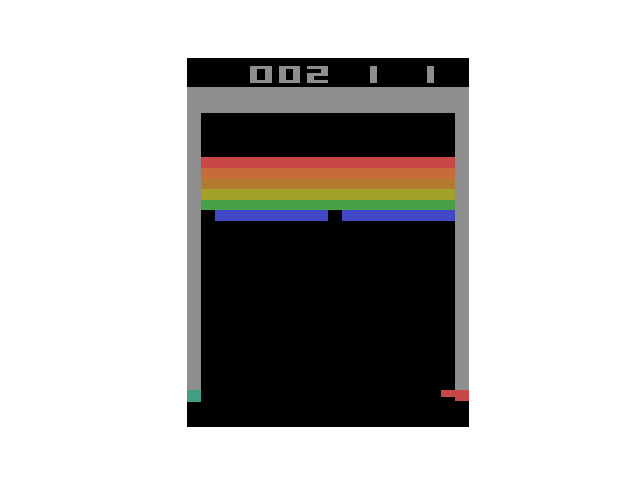

In [33]:
plot_animation(frames)